# Optimization with Scipy

The Attrici publication in GMD used the PyMC3 library to derive the results. This notebook shows how to estimate these counterfactuals using Scipy only, exemplarily for the `tas` variable in a single geographical cell.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
from attrici.distributions import Normal
from attrici.variables import Tas
from scipy import stats
from scipy.optimize import minimize

## Functions for estimation using Scipy

In [2]:
# constants for prior distributions for mu and sigma:
PRIOR_INTERCEPT_MU = 0
PRIOR_INTERCEPT_SIGMA = 1
PRIOR_TREND_MU = 0
PRIOR_TREND_SIGMA = 0.1

In [3]:
def linear_model_independent_param(
    oscillations, weights_fc_intercept, weights_longterm_intercept
):
    return np.dot(oscillations, weights_fc_intercept) + weights_longterm_intercept

In [4]:
def linear_model_dependent_param(
    covariates,
    weights_fc_intercept,
    weights_longterm_intercept,
    weights_fc_trend,
    weights_longterm_trend,
    predictor,
):
    weights_fc = np.concatenate([weights_fc_intercept, weights_fc_trend])
    return (
        np.dot(covariates, weights_fc)
        + weights_longterm_intercept
        + weights_longterm_trend * predictor
    )

In [5]:
def get_mu(params, predictor, covariates, modes):
    # get the respective weights (which are the control variables to the optimization) from params:
    weights_mu_longterm_intercept = params[0]
    weights_mu_longterm_trend = params[1]
    weights_mu_fc_intercept = params[2 : 2 + 2 * modes]
    weights_mu_fc_trend = params[2 + 2 * modes : 2 + 4 * modes]

    # also calculate the logp according to all prior distributions:
    logp_prior = stats.norm.logpdf(
        weights_mu_longterm_intercept,
        loc=PRIOR_INTERCEPT_MU,
        scale=PRIOR_INTERCEPT_SIGMA,
    )
    logp_prior += stats.norm.logpdf(
        weights_mu_longterm_trend, loc=PRIOR_TREND_MU, scale=PRIOR_TREND_SIGMA
    )
    logp_prior += np.sum(
        [
            stats.norm.logpdf(
                weights_mu_fc_intercept[i],
                loc=PRIOR_INTERCEPT_MU,
                scale=1 / (2 * i + 1),
            )
            for i in range(modes)
        ]
    )
    logp_prior += np.sum(
        [
            stats.norm.logpdf(
                weights_mu_fc_trend[i], loc=PRIOR_TREND_MU, scale=PRIOR_TREND_SIGMA
            )
            for i in range(modes)
        ]
    )

    return (
        linear_model_dependent_param(
            covariates,
            weights_mu_fc_intercept,
            weights_mu_longterm_intercept,
            weights_mu_fc_trend,
            weights_mu_longterm_trend,
            predictor,
        ),
        logp_prior,
    )

In [6]:
def get_sigma(params, oscillations, modes):
    # get the respective weights (which are the control variables to the optimization) from params:
    weights_sigma_longterm_intercept = params[2 + 4 * modes]
    weights_sigma_fc_intercept = params[3 + 4 * modes : 3 + 6 * modes]

    # also calculate the logp according to all prior distributions:
    logp_prior = stats.norm.logpdf(
        weights_sigma_longterm_intercept,
        loc=PRIOR_INTERCEPT_MU,
        scale=PRIOR_INTERCEPT_SIGMA,
    )
    logp_prior += np.sum(
        [
            stats.norm.logpdf(
                weights_sigma_fc_intercept[i],
                loc=PRIOR_INTERCEPT_MU,
                scale=1 / (2 * i + 1),
            )
            for i in range(modes)
        ]
    )

    return (
        np.exp(
            linear_model_independent_param(
                oscillations,
                weights_sigma_fc_intercept,
                weights_sigma_longterm_intercept,
            )
        ),
        logp_prior,
    )

In [7]:
def calc_oscillations(t, modes):
    t_scaled = (t - t.min()) / (np.timedelta64(365, "D") + np.timedelta64(6, "h"))
    x = (2 * np.pi * (np.arange(modes) + 1)) * t_scaled.values[:, None]
    return np.concatenate((np.cos(x), np.sin(x)), axis=1)

In [8]:
def calc_covariates(oscillations, predictor, modes):
    return np.concatenate(
        [oscillations, np.tile(predictor[:, None], (1, 2 * modes)) * oscillations],
        axis=1,
    )

`log_likelihood` is the cost function for the optimization:

In [9]:
def log_likelihood(params, oscillations, predictor, covariates, modes, y):
    mu, logp_mu = get_mu(params, predictor, covariates, modes)
    sigma, logp_sigma = get_sigma(params, oscillations, modes)
    logp = np.sum(
        stats.norm.logpdf(
            y,
            loc=mu,
            scale=sigma,
        )
    )
    # also add logp for the prior distributions:
    logp += logp_mu
    logp += logp_sigma

    return -logp

`estimate_parameters` does the actual optimization:

In [10]:
def estimate_parameters(predictor, oscillations, y, modes):
    # the weights are the control variables to be estimated by the optimization
    # from the perspective of scipy these are just squashed into a params array
    initial_params = np.concatenate(
        [
            np.zeros(1),  # weights_mu_longterm_intercept
            np.zeros(1),  # weights_mu_longterm_trend
            np.zeros(2 * modes),  # weights_mu_fc_intercept
            np.zeros(2 * modes),  # weights_mu_fc_trend
            np.zeros(1),  # weights_sigma_longterm_intercept
            np.zeros(2 * modes),  # weights_sigma_fc_intercept
        ]
    )

    # do the actual optimization and return the optimal control parameter
    # values, i.e. the weights:
    result = minimize(
        log_likelihood,
        initial_params,
        args=(
            oscillations,
            predictor,
            calc_covariates(oscillations, predictor, modes),
            modes,
            y,
        ),
        method="L-BFGS-B",
    )

    return result.x

`detrend` estimates the posterior distribution's parameters and maps the quantiles to yield the counterfactual time series:

In [11]:
def detrend(predictor, y, stopdate, modes=4):
    # do the actual fit to the data until stopdate:
    times = predictor.time[predictor.time <= np.datetime64(stopdate)]
    assert not np.any(y.sel(time=times).isnull())
    predictor_fit = predictor.sel(time=times)
    optimized_params = estimate_parameters(
        predictor_fit.values,
        calc_oscillations(times, modes),
        y.sel(time=times),
        modes,
    )

    # for estimating ('sampling') the posterior distribution's parameters (mu, sigma),
    # we use the full time series ('ref') as well as the counterfactual with zero predictor
    # (i.e. GMT=0; 'cfact'):
    oscillations = calc_oscillations(predictor.time, modes)

    mu_ref, _ = get_mu(
        optimized_params,
        predictor.values,
        calc_covariates(oscillations, predictor.values, modes),
        modes,
    )
    sigma_ref, _ = get_sigma(optimized_params, oscillations, modes)

    # for the counterfactual we assume predictor (=GMT) = 0
    predictor_cfact_values = np.zeros_like(predictor.values)
    mu_cfact, _ = get_mu(
        optimized_params,
        predictor_cfact_values,
        calc_covariates(oscillations, predictor_cfact_values, modes),
        modes,
    )
    sigma_cfact, _ = get_sigma(optimized_params, oscillations, modes)

    distribution_ref = Normal(mu_ref, sigma_ref)
    distribution_cfact = Normal(mu_cfact, sigma_cfact)

    cfact_scaled = distribution_cfact.invcdf(distribution_ref.cdf(y))

    return cfact_scaled

## Estimation and comparison to desired/target data

In [12]:
obs_data = xr.load_dataset("../tests/data/20CRv3-ERA5_germany_obs.nc").tas
gmt = xr.load_dataset("../tests/data/20CRv3-ERA5_germany_ssa_gmt.nc").tas

First, we interpolate and scale the preditor, GMT:

In [13]:
t_scaled = (obs_data.time - obs_data.time.min()) / (
    obs_data.time.max() - obs_data.time.min()
)

gmt_on_obs_times = np.interp(t_scaled, np.linspace(0, 1, len(gmt)), gmt)
gmt_scaled_values = (gmt_on_obs_times - gmt_on_obs_times.min()) / (
    gmt_on_obs_times.max() - gmt_on_obs_times.min()
)
gmt_scaled = xr.DataArray(
    gmt_scaled_values, coords={"time": obs_data.time}, dims=("time",)
)

Also, create a variable object of class `Tas`, which internally scales the data (to `var.y_scaled`):

In [14]:
var = Tas(obs_data.sel(lon=9.25, lat=50.75))

Now calculate the counterfactual using Scipy only:

In [15]:
cfact_scaled = detrend(gmt_scaled, var.y_scaled, "2021-12-31")

and rescale it according the the scaling done before:

In [16]:
cfact = cfact_scaled * var.scale.item() + var.datamin.item()

Now load the target ('desired') data and store both `desired` and `scipy` counterfactuals in the date frame:

In [17]:
data = pd.read_hdf("../tests/data/20CRv3-ERA5_germany_target_tas_lat50.75_lon9.25.h5")
data["time"] = data.ds
data.index = data.time
data["desired"] = data.cfact
data["scipy"] = cfact

### Differences

Differences between both time series (actual and desired) are:

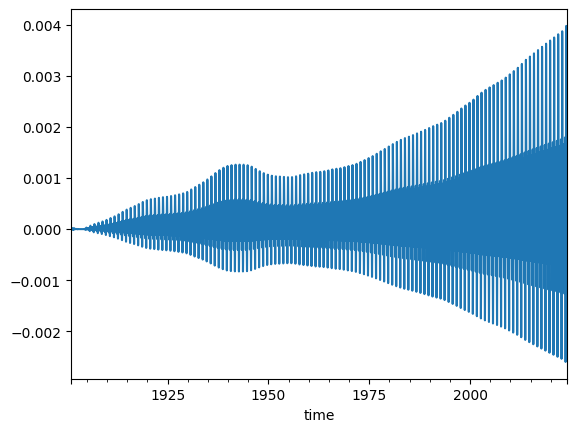

In [18]:
(data.desired - data.scipy).plot();

On an absolute scale, these differences are minor (here, for a single year)

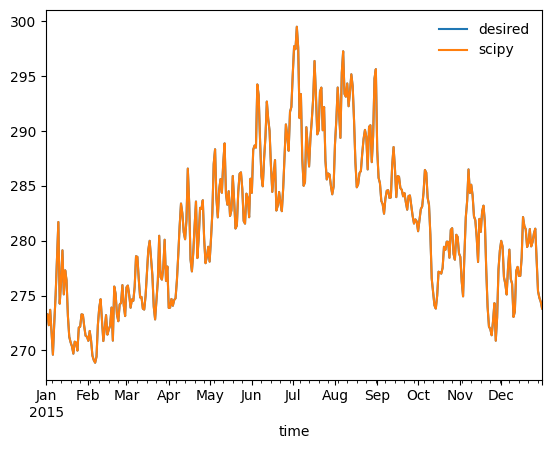

In [25]:
fig, ax = plt.subplots()
year = "2015"
data.desired.loc[year].plot(ax=ax, label="desired")
data.scipy.loc[year].plot(ax=ax, label="scipy")
ax.legend(frameon=False);

As can be seen from the histogram below, the overall distributions match fairly well:

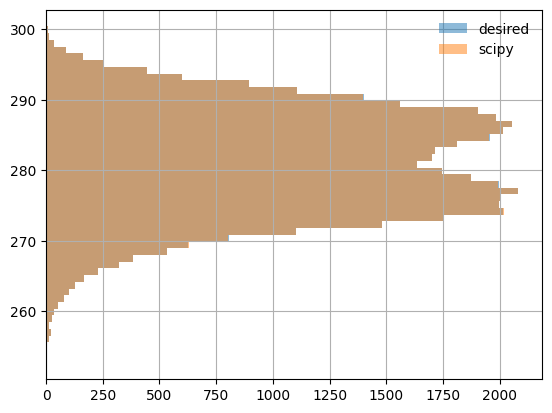

In [27]:
fig, ax = plt.subplots()
data.desired.hist(ax=ax, bins=50, label="desired", orientation="horizontal", alpha=0.5)
data.scipy.hist(ax=ax, bins=50, label="scipy", orientation="horizontal", alpha=0.5)
ax.legend(frameon=False);